In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score) 
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 


In [4]:
metabric_df = pd.read_csv("./METABRIC_RNA_Mutation.csv") 
metabric_df.shape 
metabric_df.info(verbose=True) 
metabric_df.sample(5) 
metabric_df = metabric_df.set_index('patient_id') 
df_expression = metabric_df.iloc[:, 30:519].join(metabric_df['overall_survival'], how='inner') 
metabric_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 693 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    patient_id                      int64  
 1    age_at_diagnosis                float64
 2    type_of_breast_surgery          object 
 3    cancer_type                     object 
 4    cancer_type_detailed            object 
 5    cellularity                     object 
 6    chemotherapy                    int64  
 7    pam50_+_claudin-low_subtype     object 
 8    cohort                          float64
 9    er_status_measured_by_ihc       object 
 10   er_status                       object 
 11   neoplasm_histologic_grade       float64
 12   her2_status_measured_by_snp6    object 
 13   her2_status                     object 
 14   tumor_other_histologic_subtype  object 
 15   hormone_therapy                 int64  
 16   inferred_menopausal_state       object 
 17   integrative_

C:\Users\Aniket\AppData\Local\Temp\ipykernel_15788\833086060.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  metabric_df = pd.read_csv("./METABRIC_RNA_Mutation.csv")


,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [12]:
metrics_summary = {"Model": [], "F1 Score": [], "Accuracy": []} 


In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name): 
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None 
    f1 = f1_score(y_test, y_pred, average='weighted') 
    accuracy = accuracy_score(y_test, y_pred) 
    metrics_summary["Model"].append(model_name) 
    metrics_summary["F1 Score"].append(f1) 
    metrics_summary["Accuracy"].append(accuracy) 
    print(f"\n=== {model_name} ===") 
    print("Classification Report:\n", classification_report(y_test, y_pred)) 
    print(f"Accuracy: {accuracy:.4f}") 
    print(f"F1 Score: {f1:.4f}") 
    cm = confusion_matrix(y_test, y_pred) 
    plt.figure(figsize=(6, 4)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1']) 
    plt.title(f'Confusion Matrix - {model_name}') 
    plt.xlabel('Predicted Label') 
    plt.ylabel('True Label') 
    plt.show() 
    if y_proba is not None: 
        print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.4f}") 


In [8]:
def main(df, target_column): 
    X = df.drop(target_column, axis=1) 
    y = df[target_column] 
    X = pd.get_dummies(X, drop_first=True) 
    if y.dtype == 'object': 
        y = LabelEncoder().fit_transform(y) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    models = { 
        'Random Forest': RandomForestClassifier(), 
        'Support Vector Classifier': SVC(probability=True), 
    } 
    for name, model in models.items(): 
        evaluate_model(model, X_train, X_test, y_train, y_test, name) 
    plt.figure(figsize=(10, 5)) 
    sns.barplot(x=metrics_summary["Model"], y=metrics_summary["F1 Score"], palette='coolwarm') 
    plt.xticks(rotation=45) 
    plt.title('F1 Scores of All Models') 
    plt.ylabel('F1 Score') 
    plt.show() 
    plt.figure(figsize=(10, 5)) 
    sns.barplot(x=metrics_summary["Model"], y=metrics_summary["Accuracy"], palette='coolwarm') 
    plt.xticks(rotation=45) 
    plt.title('Accuracy Scores of All Models') 
    plt.ylabel('Accuracy') 
    plt.show() 



=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.79      0.72       343
           1       0.54      0.37      0.44       229

    accuracy                           0.62       572
   macro avg       0.60      0.58      0.58       572
weighted avg       0.61      0.62      0.60       572

Accuracy: 0.6224
F1 Score: 0.6044


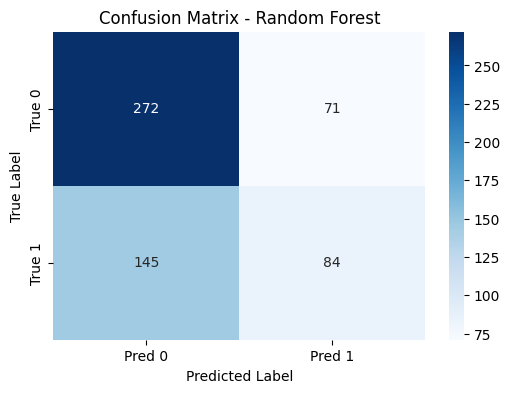

AUC-ROC Score: 0.6406

=== Support Vector Classifier ===
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.79      0.73       343
           1       0.59      0.45      0.51       229

    accuracy                           0.66       572
   macro avg       0.64      0.62      0.62       572
weighted avg       0.65      0.66      0.65       572

Accuracy: 0.6556
F1 Score: 0.6454


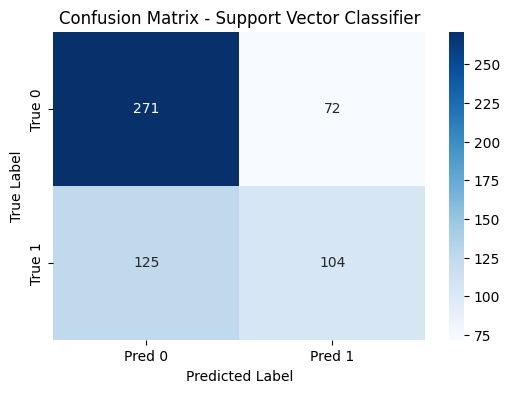

AUC-ROC Score: 0.6740


C:\Users\Aniket\AppData\Local\Temp\ipykernel_4044\3979935966.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_summary["Model"], y=metrics_summary["F1 Score"], palette='coolwarm')


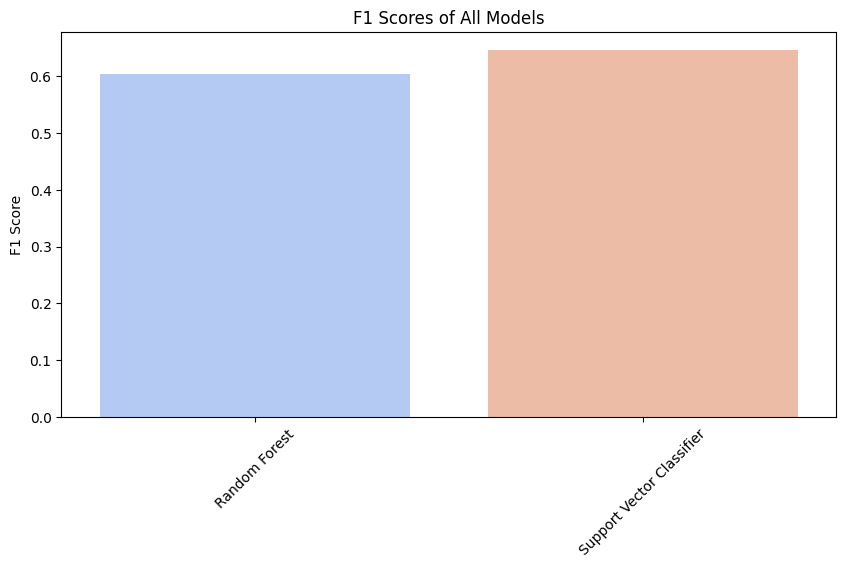

C:\Users\Aniket\AppData\Local\Temp\ipykernel_4044\3979935966.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_summary["Model"], y=metrics_summary["Accuracy"], palette='coolwarm')


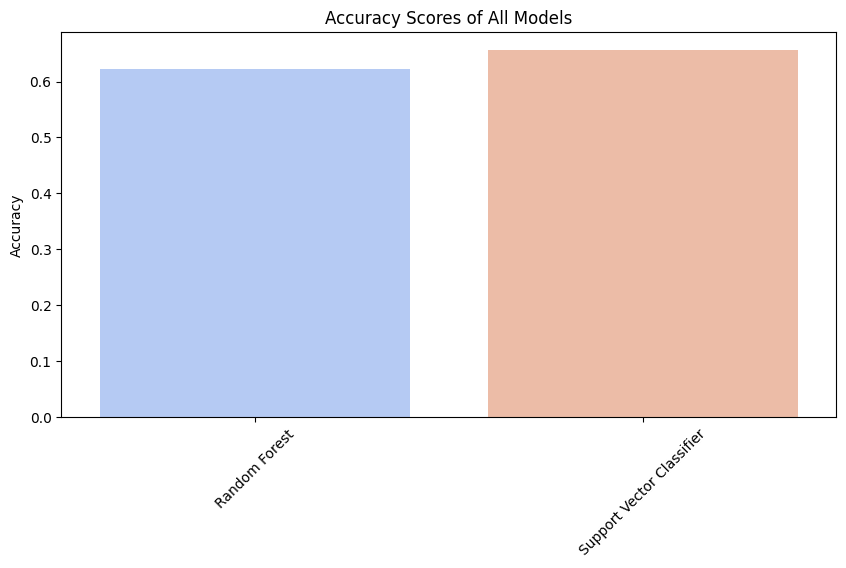

In [9]:
if __name__ == "__main__": 
    df = df_expression  # Example input dataframe 
    target_column = 'overall_survival'  # Replace with the actual target column name 
    main(df, target_column) 
